In [ ]:
!cp '/content/drive/MyDrive/3rd Year/ANLE/Lab1/wk1labresources.zip' 'rsc.zip'
!cp '/content/drive/MyDrive/3rd Year/ANLE/Lab1/GoogleNews-vectors-negative300.bin.gz' 'GoogleNews-vectors-negative300.bin.gz'
!unzip 'rsc.zip'

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('wordnet_ic')

import operator
from nltk.corpus import wordnet as wn, wordnet_ic as wn_ic, lin_thesaurus as lin

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import spearmanr, linregress

from gensim.models import KeyedVectors

In [ ]:
wn.synsets("book")
wn.synsets("book",wn.NOUN)
synsetA=wn.synsets("book",wn.NOUN)[0]
synsetA.definition()
synsetA.hyponyms()
synsetA.hypernyms()
synsetB=wn.synsets("book",wn.NOUN)[1]
synsetA.path_similarity(synsetB)
brown_ic=wn_ic.ic("ic-brown.dat")
synsetA.res_similarity(synsetB,brown_ic)
synsetA.lin_similarity(synsetB,brown_ic)

# 2.1 Tasks

1. Write a function to return the path similarity of two nouns. Remember this is the maximum
similarity of all of the possible pairings of the two nouns. Make sure you test it. For (chicken,car)
the correct answer is 0.0909 (3sf).

2. Generalise it so that you have an extra (optional) parameter which you use to select the WordNet
similarity measure e.g., res similarity and lin similarity.

In [5]:
def noun_similarity(w1, w2, measure_fn = 'path', ic = None):
  synset1 = wn.synsets(w1, wn.NOUN)
  synset2 = wn.synsets(w2, wn.NOUN)
  mx = -9999
  
  for sense1 in synset1:
    for sense2 in synset2:
      if measure_fn == 'path':
        s = sense1.path_similarity(sense2)
      elif measure_fn == 'res':
        s = sense1.res_similarity(sense2, ic)
      elif measure_fn == 'lch':
        s = sense1.lch_similarity(sense2, ic)
      elif measure_fn == 'wup':
        s = sense1.wup_similarity(sense2, ic)
      elif measure_fn == 'jcn':
        s = sense1.jcn_similarity(sense2, ic)
      elif measure_fn == 'lin':
        s = sense1.lin_similarity(sense2, ic)
      mx = max(mx, s)

  return mx

In [7]:
noun_similarity('football', 'cake', 'path', brown_ic)

0.125

# 3.1 Tasks


1. Read in mcdata.csv and store it in an appropriate format so that you can obtain a list of pairs of
nouns and the score associated with each pair.
2. Calculate the similarity score for each pair of nouns using at least 2 semantic similarity measures.
3. Correlate each of the calculated sets of scores with each other and with the human judgements (I
suggest you use scipy.stats.spearmanr() or pandas for this).
4. What do you conclude?

The Miller & Charles human judgements correlate most with the Jiang-Conrath Similarity. A score denoting how similar two word senses are, based on the Information Content (IC) of the Least Common Subsumer and that of the two input Synsets. The relationship is given by the equation 1 / (IC(s1) + IC(s2) - 2 * IC(lcs)). Leacock-Chodorow Similarity correlates highly with Wu-Palmer Similarity, all measures correlate with each other to an extent with the lowest Spearman's rank correlation coefficient being 0.72 between human judgement and Leacock-Chodorow Similarity. JCN seemes to get its high human correlation from the fact that it can produce very low scores that match with some of the very low human scores, where as other measures seem unlikely to produce scores under 0.1. This is demonstrated well in the scatter plots in section 5.

In [52]:
df = pd.read_csv('wk1labresources/mcdata.csv', names=['Word1', 'Word2', 'Human'])

df[3] = [noun_similarity(row['Word1'], row['Word2'], 'res', brown_ic) for index, row in df.iterrows()]
df[4] = [noun_similarity(row['Word1'], row['Word2'], 'lch', brown_ic) for index, row in df.iterrows()]
df[5] = [noun_similarity(row['Word1'], row['Word2'], 'wup', brown_ic) for index, row in df.iterrows()]
df[6] = [noun_similarity(row['Word1'], row['Word2'], 'jcn', brown_ic) for index, row in df.iterrows()]
df[7] = [noun_similarity(row['Word1'], row['Word2'], 'lin', brown_ic) for index, row in df.iterrows()]
df.rename(columns={3: 'res', 4: 'lch', 5: 'wup', 6: 'jcn', 7: 'lin'}, inplace=True)


df.corr(method='spearman')

,Human,res,lch,wup,jcn,lin
Human,1.000000,0.735945,0.722743,0.750534,0.825738,0.753510
res,0.735945,1.000000,0.900648,0.915520,0.886012,0.962707
lch,0.722743,0.900648,1.000000,0.987498,0.873062,0.945509
wup,0.750534,0.915520,0.987498,1.000000,0.883328,0.952724
jcn,0.825738,0.886012,0.873062,0.883328,1.000000,0.934315
lin,0.753510,0.962707,0.945509,0.952724,0.934315,1.000000


In [53]:
df

,Word1,Word2,Human,res,lch,wup,jcn,lin
0,asylum,madhouse,3.61,9.475167,2.944439,0.952381,3.126296e-01,0.855584
1,bird,cock,3.05,7.677755,2.944439,0.952381,2.229525e-01,0.773937
2,bird,crane,2.97,7.677755,2.251292,0.869565,1.931096e-01,0.747812
3,boy,lad,3.76,8.399492,2.944439,0.947368,2.917961e-01,0.830562
4,brother,monk,2.82,9.261593,2.944439,0.952381,3.917777e+00,0.986407
5,car,automobile,3.92,7.591401,3.637586,1.000000,1.000000e+300,1.000000
6,cemetery,woodland,0.95,1.290026,1.440362,0.428571,5.458198e-02,0.123441
7,chord,smile,0.13,2.619644,1.239691,0.375000,6.235766e-02,0.246256
8,coast,forest,0.42,1.290026,1.845827,0.545455,5.824660e-02,0.130646
9,coast,hill,0.87,5.884681,2.028148,0.666667,1.269797e-01,0.599113


# 4.1 Tasks

1. Repeat the tasks in Section 3 using similarity scores from the word2vec model. Make sure you
correlate the word2vec similarities with the human synonymy judgements and the wordnet similarity
scores.
2. What do you conclude?

Word2Vec produces the highest correlation with human judgements bar the Jiang-Conrath Similarity. It's interesting to see that SRCC suggests minimal correlation between Word2Vec and the WordNet measures, even though the measures all correlate to the human judgement. This suggests that words with dissilimar similarity scores from WordNet are more similar using Word2Vec. However, it is difficult to compare any of these measures as they are due to the difference in their scaling. For example, wup, lin and Word2Vec produces scores between 0 and 1, whereas res, lch and jcn produce scores beyond 1.

In [11]:
word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [16]:
df[8] = [word2vec.similarity(row['Word1'], row['Word2']) for index, row in df.iterrows()]
df.rename(columns={8: 'w2v'}, inplace=True)

df.corr(method='spearman')

,Human,res,lch,wup,jcn,lin,w2v
Human,1.000000,0.735945,0.722743,0.750534,0.825738,0.753510,0.786557
res,0.735945,1.000000,0.900648,0.915520,0.886012,0.962707,0.573820
lch,0.722743,0.900648,1.000000,0.987498,0.873062,0.945509,0.582529
wup,0.750534,0.915520,0.987498,1.000000,0.883328,0.952724,0.597392
jcn,0.825738,0.886012,0.873062,0.883328,1.000000,0.934315,0.556633
lin,0.753510,0.962707,0.945509,0.952724,0.934315,1.000000,0.586323
w2v,0.786557,0.573820,0.582529,0.597392,0.556633,0.586323,1.000000


In [50]:
df[df['jcn'] > 100] = np.NaN # get rid of jcn values of e^300

# 5 Extension: Significance Testing

How much better does one measure need to be than another in order for it to be a significant difference?
If a different set of pairs of words had been chosen, how likely is it that you would have come to a
different conclusion? This is a very hard question to answer conclusively but most notions of statistical
significance are based on the size of the sample (bigger sample more likely to be significant) and the
amount of variance in the sample (less variance implies more likely to be significant). Here we are going
to attempt to estimate the significance of your results from Section 3.
1. For each of the similarity measures you have considered, plot a scatter graph of word net-based
similarity scores against human semantic judgments. You could use the scatter function from
matplotlib or pandas for this. Make sure you add labels to the x and y axes and a title.
2. Add a text box to the graph to display the correlation coefficient and the p-value. What does this
p-value mean?

The values are very low indicating minimal statistical significance. This is likely because of the small sample size.

3. Calculate the regression line (i.e., the line of best fit) for each data set and display it on the graph.
You can use scipy.stats.linregress() to calculate the regression line. Does this function return
the same correlation coefficient as scipy.stats.spearmanr()?

No the correlation coefficients are different, it looks as though the linear regression method produces similar results to pearson's correlational method.

4. One way to get a handle on whether the differences between two correlation coefficients are significant
is to construct 95% confidence intervals for those coefficients. A p% confidence interval should
capture the true value p% of the time. Therefore if the confidence intervals don’t overlap, there is
a very small chance (< 0.0252
) that the one which has been observed to be the best is not the best.
Common ways to construct confidence intervals include the Central Limit Theorem, cross-validation
and bootstrapping. Here we will use bootstrapping2.
In order to construct a 95% confidence interval of the correlation coefficient for n points.

*   Take a random sample of n points (with replacement!).
*   Calculate the correlation coefficient for the random sample.
*   Repeat at least 100 times (1000 or 10000 would be better).
*   Find the 2.5% and 97.5% percentiles from the list of correlation coefficients found for the different random samples. This is your 95% confidence interval.

Construct 95% confidence intervals for at least 2 of the correlation coefficients. What do you conclude about the differences?

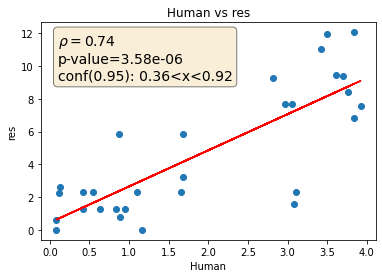

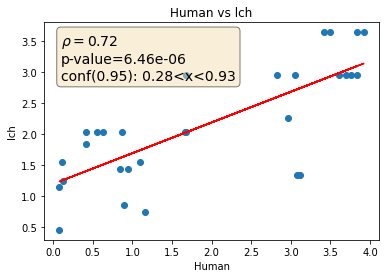

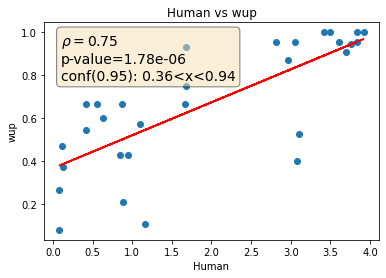

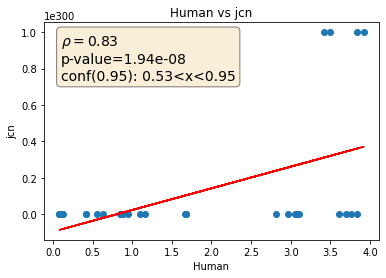

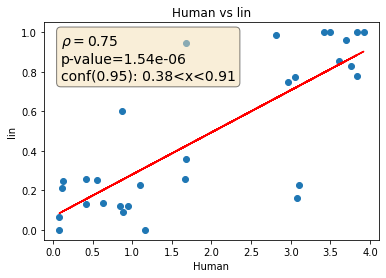

In [175]:
for measure in ['res', 'lch', 'wup', 'jcn', 'lin']:
  fig, ax = plt.subplots()
  
  ax.scatter(x=df['Human'], y=df[measure])
  ax.set_xlabel('Human')
  ax.set_ylabel(measure)
  ax.set_title('Human vs {}'.format(measure))

  n = 10
  interval = 0.95
  srccs = []
  for i in range(1000):
    sample = df.sample(n)
    srcc = sample['Human'].corr(sample[measure], method='spearman')
    srccs.append(srcc)
  srccs = pd.DataFrame(srccs)

  res = linregress(df['Human'],df[measure])
  ax.plot(df['Human'], res.intercept + res.slope*df['Human'], 'r', label='fitted line')
  
  textstr = r'$\rho={:.2f}$''\np-value={:.2e}\nconf({}): {:.2f}<x<{:.2f}'.format(df['Human'].corr(df[measure], method='spearman'), spearmanr(df['Human'],df[measure])[1], interval, srccs.quantile((1-interval)/2)[0], srccs.quantile(1-(1-interval)/2)[0])

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

  ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

  plt.show()